In [89]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, regularizers
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from src.dataLoading import dataLoader
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import pickle
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from src.dataLoading import dataLoader
from src.featureExtraction import runPCA, mix_gauss, K_means, handcraftedFeaturesExtractor
from sklearn.model_selection import GridSearchCV

### Loading Data

In [106]:
encoder.classes_

array(['chinese_0', 'chinese_1', 'chinese_2', 'chinese_3', 'chinese_4',
       'chinese_5', 'chinese_6', 'chinese_7', 'chinese_8', 'chinese_9',
       'mnist_0', 'mnist_1', 'mnist_2', 'mnist_3', 'mnist_4', 'mnist_5',
       'mnist_6', 'mnist_7', 'mnist_8', 'mnist_9'], dtype='<U9')

In [90]:
with open('encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

In [ ]:
with open(raw_data_dir, 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)
    
encoder = LabelBinarizer()
transfomed_labels = encoder.fit(np.unique(labels))

In [92]:
#PCA data
with open('data_splits_pca.pkl', 'rb') as f:
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = pickle.load(f)

In [93]:
#Handcrafted data
with open('data_splits_hand.pkl', 'rb') as f:
    X_train_hand, X_test_hand, y_train_hand, y_test_hand = pickle.load(f)
    

### CNN

In [94]:
cnn = tf.keras.models.load_model('saved_models/weights-109-0.0715.hdf5')
cnn.summary()
test_loss, test_acc = cnn.evaluate(X_test[:], y_test_t[:], verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 26, 26, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
batch_normalization_3 (Batch (None, 11, 11, 32)        128       
_________________________________________________________________
activation_3 (Activation)    (None, 11, 11, 32)       

### Gradient Boosting PCA

In [95]:
gb_dir = 'saved_models/pca_gb.pkl'
with open(gb_dir, 'rb') as f:
    gb_PCA = pickle.load(f)

C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DummyClassifier from version 1.2.0 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.2.0 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 1.2.0 when using version 1.1.3. This might lead to breaking code or i

### Gradient Boosting Handcrafted

In [96]:
gb_dir = 'saved_models/hand_gb.pkl'
with open(gb_dir, 'rb') as f:
    gb_HAND = pickle.load(f)

### SVM PCA

In [97]:
gb_dir = 'saved_models/pca_svm.pkl'
with open(gb_dir, 'rb') as f:
    svm_PCA = pickle.load(f)

C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SVC from version 1.2.0 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### SVM Handcrafted

In [98]:
gb_dir = 'saved_models/hand_svm.pkl'
with open(gb_dir, 'rb') as f:
    svm_HAND = pickle.load(f)

In [167]:
models = {
    "cnn": {
        "title": "CNN",
        "model": cnn,
        "data": {
            "y_one_hot": True,
            "x": X_test,
            "y": y_test
        }
    },
    "svm_PCA": {
        "title": "SVM PCA",
        "model": svm_PCA,
         "data": {
            "y_one_hot": False,
            "x": X_test_pca,
            "y": y_test_pca
        }
    },
    "svm_HAND": {
        "title": "SVM Handcrafted",
        "model": svm_HAND,
         "data": {
            "y_one_hot": False,
            "x": X_test_hand,
            "y": y_test_hand
        }
    },
    "gb_PCA": {
        "title": "Gradient Boosting PCA",
        "model": gb_PCA,
         "data": {
            "y_one_hot": False,
            "x": X_test_pca,
            "y": y_test_pca
        }
    },
    "gb_HAND": {
        "title": "Gradient Boosting Handcrafted",
        "model": gb_HAND,
         "data": {
            "y_one_hot": False,
            "x": X_test_hand,
            "y": y_test_hand
        }
    },
}

In [173]:
def predict(model, data):
    y_pred = model.predict(data['x'])
    y = data['y']
    if(data['y_one_hot']):
        print('de encoding')
        y_pred = encoder.inverse_transform(y_pred)
    return y_pred
    
def create_cm(y_pred, y, labels=None):
    y_pred_df = pd.DataFrame([y_pred , y], index=pd.Index(['pred', 'real'])).transpose()
    if(labels is not None):
        y_pred_df = y_pred_df[y_pred_df['real'].isin(labels)]
        other_labels = list(set(encoder.classes_).difference(set(labels)))
        print(len(other_labels))
        y_pred_df['pred'].replace(to_replace=other_labels, value = 'OTHER', inplace=True)
    cm = confusion_matrix(y_pred_df.real ,y_pred_df.pred)
    if(cm.shape[0] > len(labels)):
        print(cm.shape)
        labels = ['OTHER'] + list(labels)
        print('others')
    print(classification_report(y_pred_df.real, y_pred_df.pred, target_names=labels, digits=4))
    return cm, labels

def plot_cm(cm, labels, title=''):
    plt.figure(figsize=(9,9))
    ax= plt.subplot()
    cm_array_df = pd.DataFrame(cm, index=pd.Index(labels), columns=labels)
    sns.heatmap(cm_array_df, annot=True, ax=ax, cmap='viridis', fmt='g')
    plt.title(f'{title}')
    plt.savefig(f'figures/cm_{"_".join(title.split(" "))}.png')
    


--------------------------------------------------
cnn
de encoding
0
              precision    recall  f1-score   support

   chinese_0     1.0000    1.0000    1.0000       200
   chinese_1     0.9950    0.9950    0.9950       200
   chinese_2     0.9950    1.0000    0.9975       200
   chinese_3     1.0000    0.9950    0.9975       200
   chinese_4     0.9950    1.0000    0.9975       200
   chinese_5     1.0000    0.9950    0.9975       200
   chinese_6     0.9950    1.0000    0.9975       200
   chinese_7     0.9950    0.9900    0.9925       200
   chinese_8     1.0000    1.0000    1.0000       200
   chinese_9     1.0000    1.0000    1.0000       200
     mnist_0     0.9901    1.0000    0.9950       200
     mnist_1     0.9949    0.9800    0.9874       200
     mnist_2     0.9707    0.9950    0.9827       200
     mnist_3     0.9950    0.9900    0.9925       200
     mnist_4     0.9900    0.9950    0.9925       200
     mnist_5     0.9949    0.9700    0.9823       200
     mnist_6

C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM PCA CHINESE
10
              precision    recall  f1-score   support

     mnist_0     0.9851    0.9950    0.9900       200
     mnist_1     0.9852    1.0000    0.9926       200
     mnist_2     0.9798    0.9700    0.9749       200
     mnist_3     0.9548    0.9500    0.9524       200
     mnist_4     0.9608    0.9800    0.9703       200
     mnist_5     0.9653    0.9750    0.9701       200
     mnist_6     0.9849    0.9800    0.9825       200
     mnist_7     0.9653    0.9750    0.9701       200
     mnist_8     0.9548    0.9500    0.9524       200
     mnist_9     0.9688    0.9300    0.9490       200

    accuracy                         0.9705      2000
   macro avg     0.9705    0.9705    0.9704      2000
weighted avg     0.9705    0.9705    0.9704      2000

--------------------------------------------------
svm_HAND
0
              precision    recall  f1-score   support

   chinese_0     0.4000    0.4500    0.4235       200
   chinese_1     0.9268    0.9500    0.9383       2

C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM Handcrafted CHINESE
10
(11, 11)
others
              precision    recall  f1-score   support

       OTHER     0.0000    0.0000    0.0000         0
     mnist_0     0.4074    0.3850    0.3959       200
     mnist_1     0.9364    0.8100    0.8686       200
     mnist_2     0.3497    0.2500    0.2915       200
     mnist_3     0.2701    0.1850    0.2196       200
     mnist_4     0.3609    0.3050    0.3306       200
     mnist_5     0.2000    0.1300    0.1576       200
     mnist_6     0.4485    0.3700    0.4055       200
     mnist_7     0.4220    0.3650    0.3914       200
     mnist_8     0.4078    0.2100    0.2772       200
     mnist_9     0.3359    0.2150    0.2622       200

    accuracy                         0.3225      2000
   macro avg     0.3762    0.2932    0.3273      2000
weighted avg     0.4139    0.3225    0.3600      2000



C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------
gb_PCA
0
              precision    recall  f1-score   support

   chinese_0     0.9949    0.9850    0.9899       200
   chinese_1     0.9900    0.9950    0.9925       200
   chinese_2     0.9848    0.9700    0.9773       200
   chinese_3     0.9606    0.9750    0.9677       200
   chinese_4     0.9752    0.9850    0.9801       200
   chinese_5     0.9948    0.9650    0.9797       200
   chinese_6     0.9698    0.9650    0.9674       200
   chinese_7     0.9602    0.9650    0.9626       200
   chinese_8     0.9752    0.9850    0.9801       200
   chinese_9     0.9738    0.9300    0.9514       200
     mnist_0     0.9602    0.9650    0.9626       200
     mnist_1     0.9657    0.9850    0.9752       200
     mnist_2     0.9397    0.9350    0.9373       200
     mnist_3     0.9020    0.9200    0.9109       200
     mnist_4     0.8977    0.9650    0.9301       200
     mnist_5     0.9034    0.9350    0.9189       200
     mnist_6     0.97

C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       OTHER     0.0000    0.0000    0.0000         0
   chinese_0     1.0000    0.9850    0.9924       200
   chinese_1     0.9900    0.9950    0.9925       200
   chinese_2     0.9848    0.9700    0.9773       200
   chinese_3     0.9606    0.9750    0.9677       200
   chinese_4     0.9850    0.9850    0.9850       200
   chinese_5     0.9948    0.9650    0.9797       200
   chinese_6     0.9747    0.9650    0.9698       200
   chinese_7     0.9602    0.9650    0.9626       200
   chinese_8     0.9801    0.9850    0.9825       200
   chinese_9     0.9738    0.9300    0.9514       200

    accuracy                         0.9720      2000
   macro avg     0.8913    0.8836    0.8874      2000
weighted avg     0.9804    0.9720    0.9761      2000

Gradient Boosting PCA CHINESE
10
(11, 11)
others


C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       OTHER     0.0000    0.0000    0.0000         0
     mnist_0     0.9650    0.9650    0.9650       200
     mnist_1     0.9752    0.9850    0.9801       200
     mnist_2     0.9590    0.9350    0.9468       200
     mnist_3     0.9064    0.9200    0.9132       200
     mnist_4     0.9061    0.9650    0.9346       200
     mnist_5     0.9212    0.9350    0.9280       200
     mnist_6     0.9744    0.9500    0.9620       200
     mnist_7     0.9692    0.9450    0.9570       200
     mnist_8     0.9330    0.9050    0.9188       200
     mnist_9     0.9179    0.8950    0.9063       200

    accuracy                         0.9400      2000
   macro avg     0.8570    0.8545    0.8556      2000
weighted avg     0.9427    0.9400    0.9412      2000

--------------------------------------------------
gb_HAND
0
              precision    recall  f1-score   support

   chinese_0     0.9604    0.9700    0.9652       200
   chinese_1     

C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Gradient Boosting Handcrafted CHINESE
10
(11, 11)
others
              precision    recall  f1-score   support

       OTHER     0.0000    0.0000    0.0000         0
     mnist_0     0.7950    0.7950    0.7950       200
     mnist_1     0.9550    0.9550    0.9550       200
     mnist_2     0.7095    0.5250    0.6034       200
     mnist_3     0.6863    0.5250    0.5949       200
     mnist_4     0.7647    0.6500    0.7027       200
     mnist_5     0.5435    0.6250    0.5814       200
     mnist_6     0.6781    0.7900    0.7298       200
     mnist_7     0.6835    0.8100    0.7414       200
     mnist_8     0.7931    0.8050    0.7990       200
     mnist_9     0.7897    0.7700    0.7797       200

    accuracy                         0.7250      2000
   macro avg     0.6726    0.6591    0.6620      2000
weighted avg     0.7398    0.7250    0.7282      2000



C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jl\Miniconda3\envs\u\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


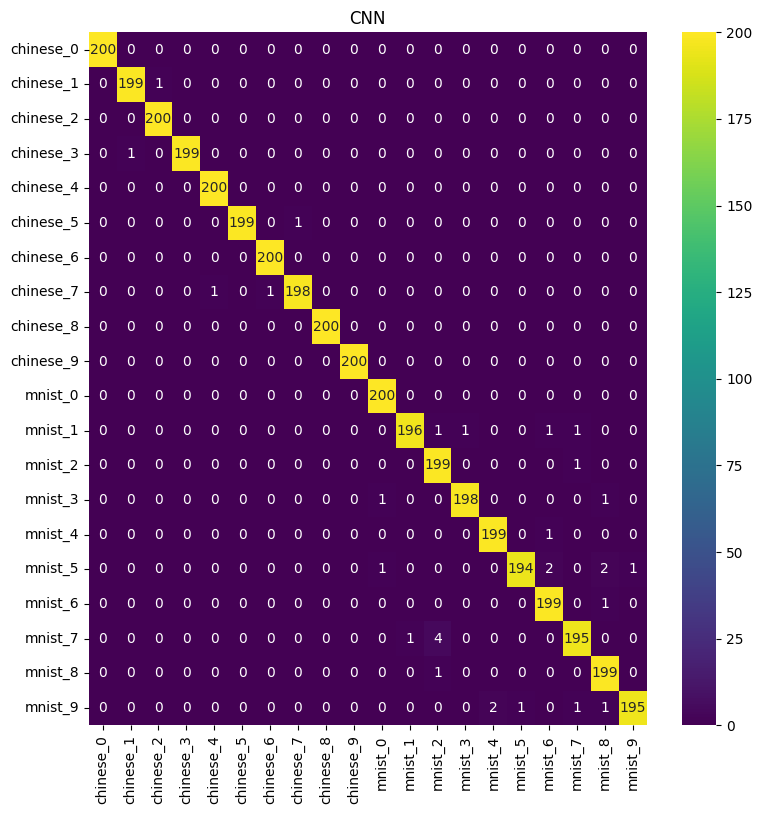

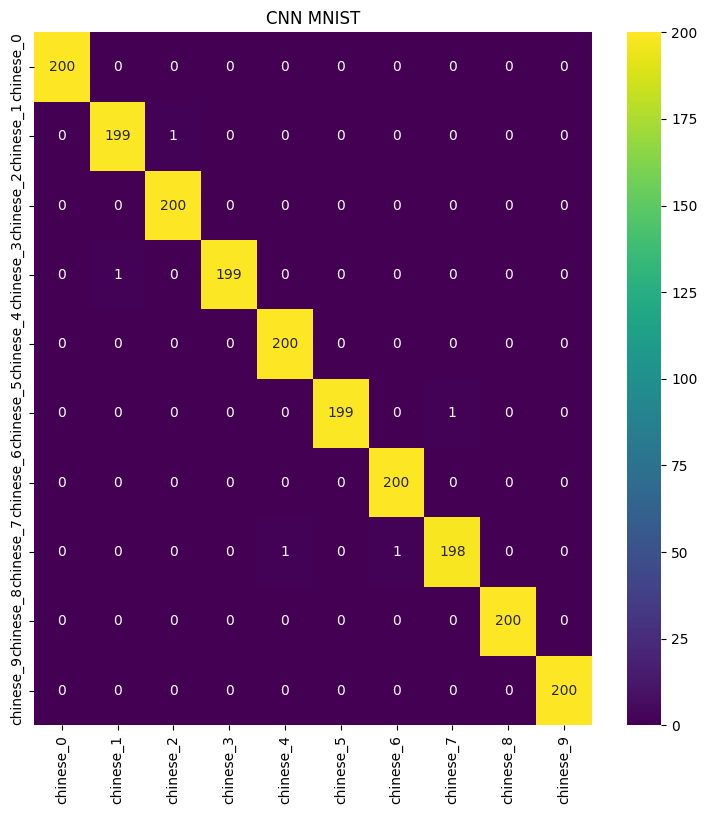

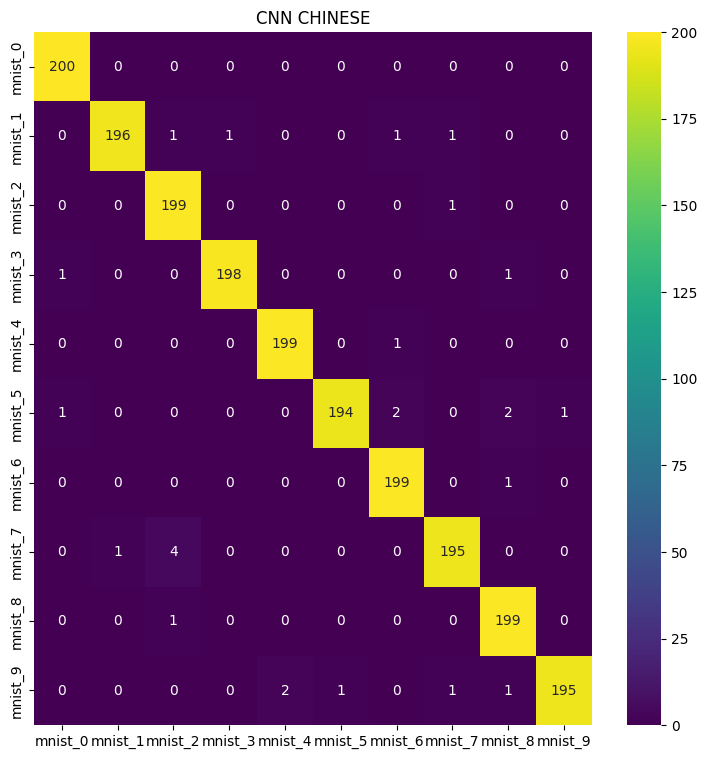

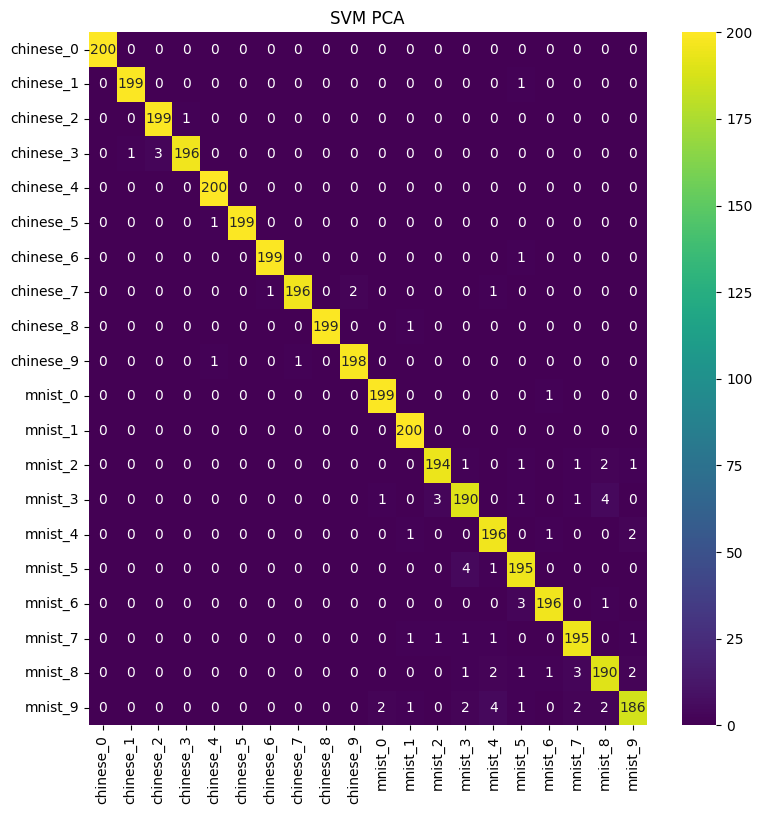

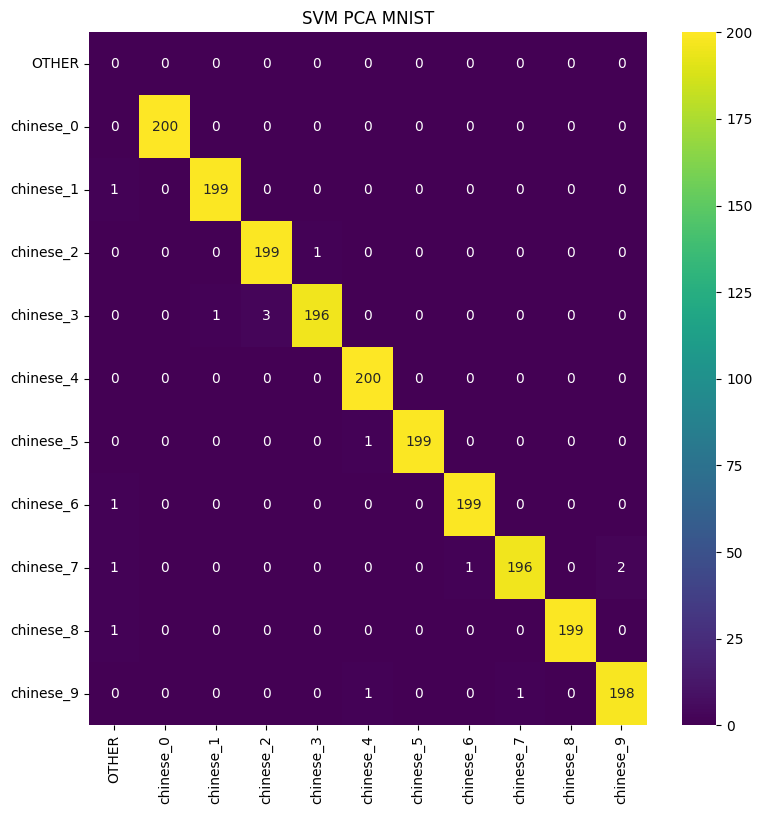

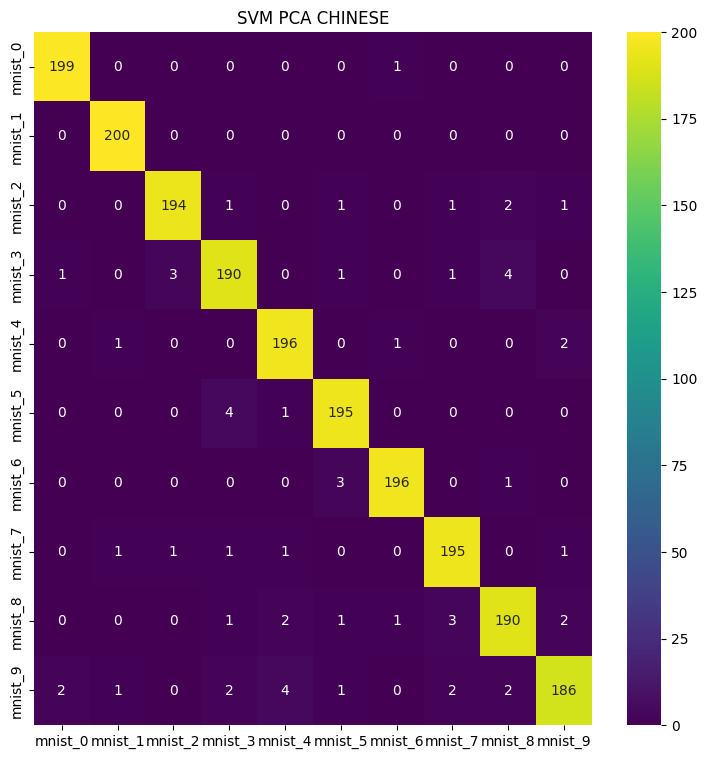

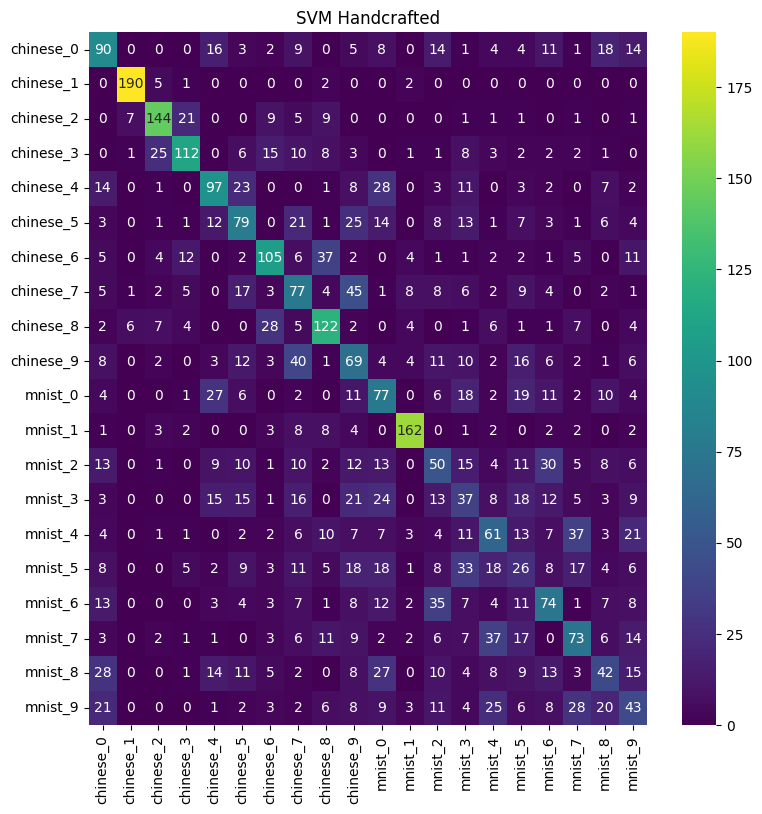

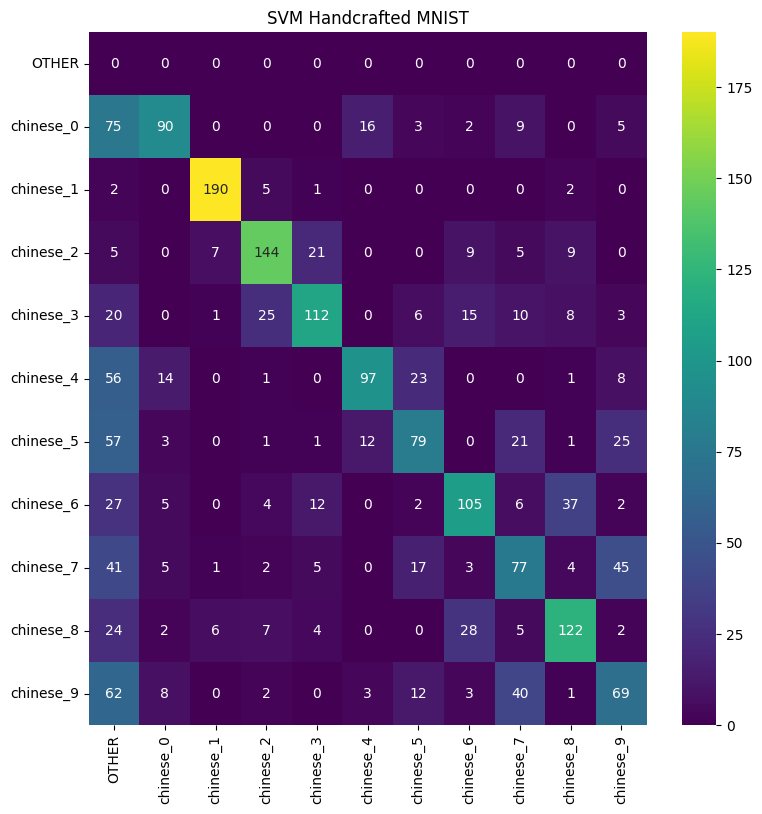

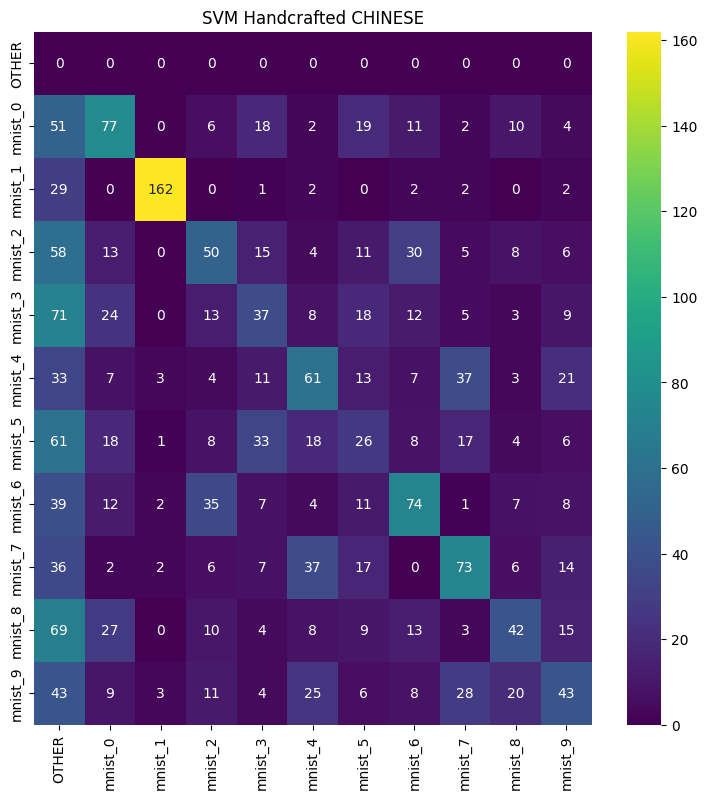

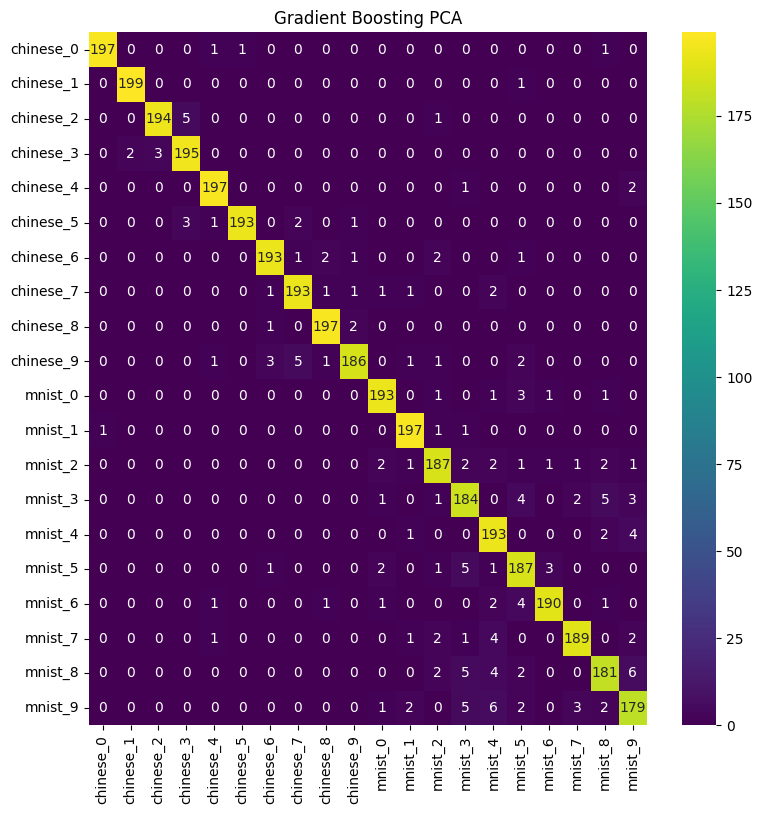

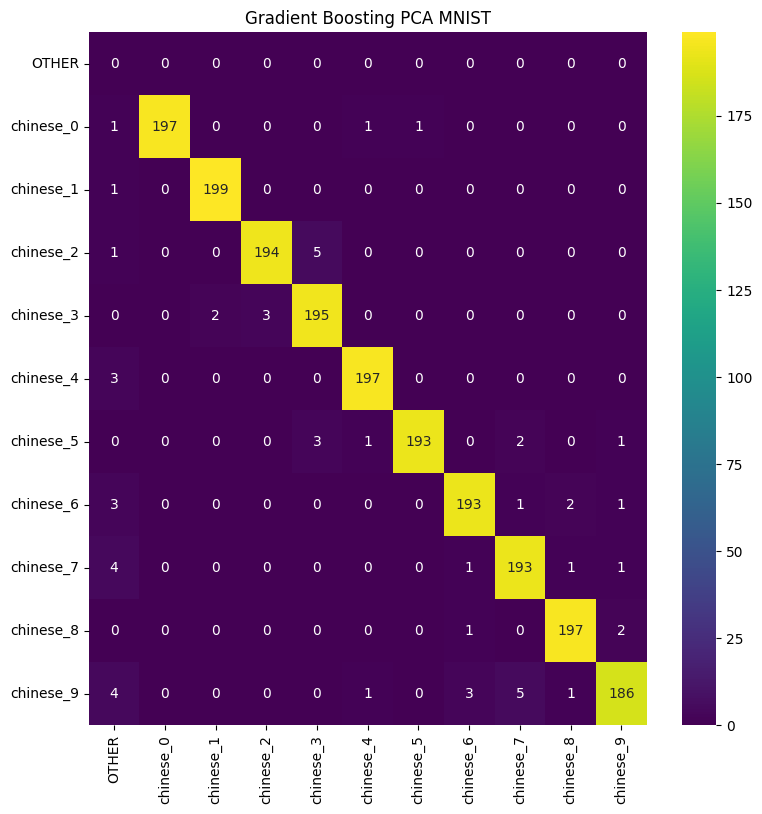

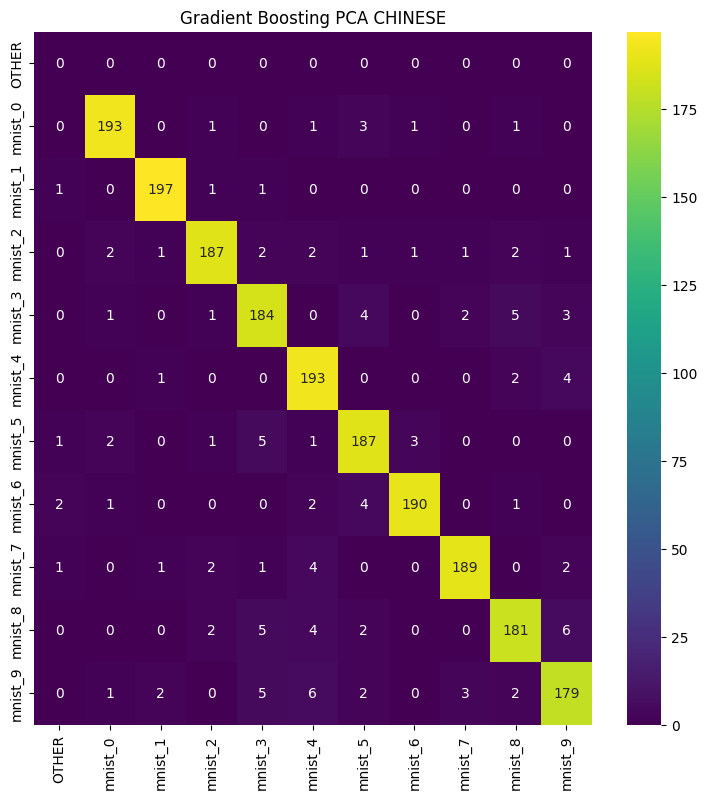

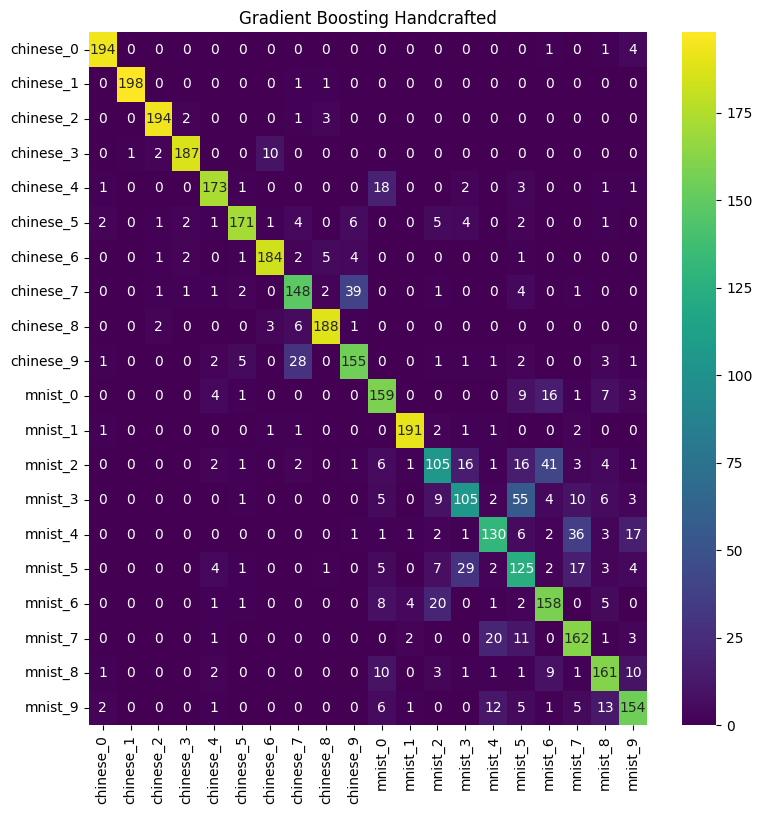

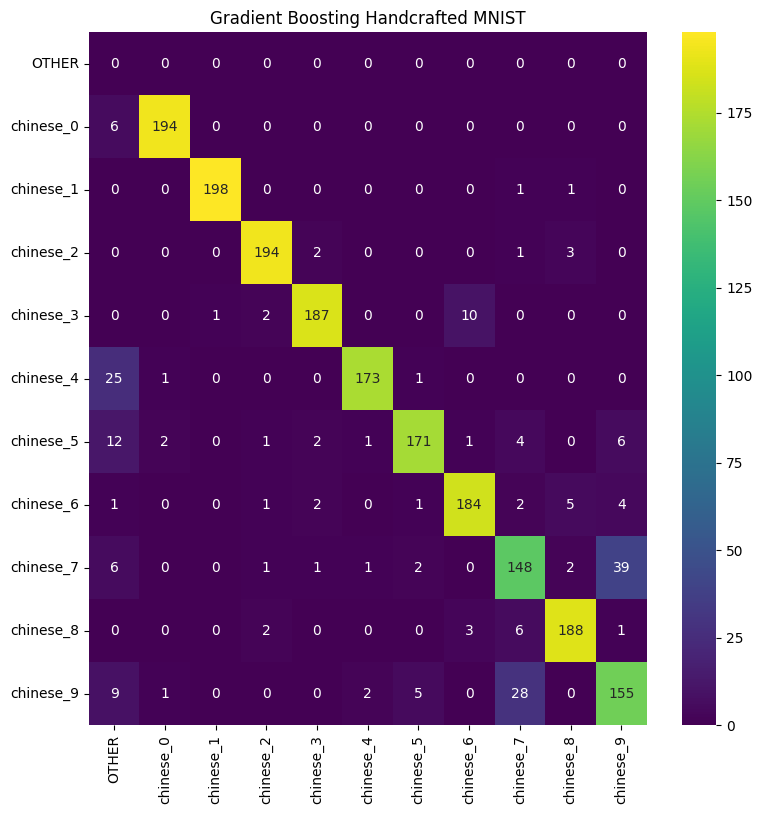

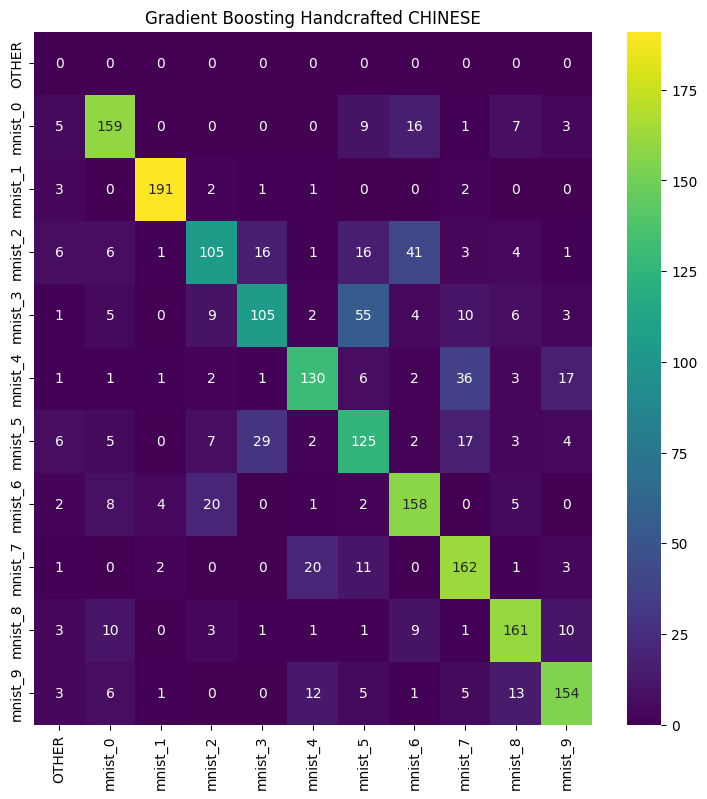

In [175]:
for key, model in models.items():
    print('-'*50)
    print(key)
    y_pred = predict(model['model'], model['data'])
    cm, labels = create_cm(y_pred, model['data']['y'], encoder.classes_)
    plot_cm(cm, labels, model['title'])
    print(model['title'] + ' MNIST')
    cm, labels = create_cm(y_pred, model['data']['y'], encoder.classes_[:10])
    plot_cm(cm, labels, model['title'] + ' MNIST')
    print(model['title'] + ' CHINESE')
    cm, labels = create_cm(y_pred, model['data']['y'], encoder.classes_[10:])
    plot_cm(cm, labels, model['title'] + ' CHINESE')